In [1]:
#1 первый датасет
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd

base_url = "https://ru.wikipedia.org"
url = "https://ru.wikipedia.org/wiki/Латинская_Америка"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'class': 'wikitable'})

table_data = []
links = []
for row in table.find_all('tr'):
    cols = row.find_all(['td', 'th'])
    if len(cols) > 1 and "Мир" not in cols[0].text.strip():
        cols_data = [col.text.strip() for col in cols[:2]]
        table_data.append(cols_data)
        a_tag = cols[0].find('a', href=True)
        if a_tag:
            links.append(urljoin(base_url, a_tag['href']))

df = pd.DataFrame(table_data, columns=["Страна", "Продолжительность жизни"])

df = df.drop([1, 2, 3]).reset_index(drop=True)

df['Координаты'] = None
df['Язык'] = None

for i, link in enumerate(links):
    country_response = requests.get(link)
    country_soup = BeautifulSoup(country_response.content, 'html.parser')

    infobox = country_soup.find('table', {'class': 'infobox'})

    capital_link = None
    official_language = None
    if infobox:
        for row in infobox.find_all('tr'):
            if row.find('th') and 'Столица' in row.find('th').text:
                capital_cell = row.find('td')
                if capital_cell:
                    capital_a_tag = capital_cell.find('a', href=True)
                    if capital_a_tag:
                        capital_link = urljoin(base_url, capital_a_tag['href'])
            if row.find('th') and ('Официальные языки' in row.find('th').text or 'Официальный язык' in row.find('th').text):
                language_cell = row.find('td')
                if language_cell:
                    official_language = language_cell.text.strip()

    if official_language:
        df.at[i, 'Язык'] = official_language
    else:
        df.at[i, 'Язык'] = "Не найдено"

    if capital_link:
        capital_response = requests.get(capital_link)
        capital_soup = BeautifulSoup(capital_response.content, 'html.parser')

        capital_infobox = capital_soup.find('table', {'class': 'infobox'})

        previous_row_value = None
        if capital_infobox:
            rows = capital_infobox.find_all('tr')
            for j in range(len(rows) - 1):
                if 'Страна' in rows[j + 1].text:
                    previous_row = rows[j]
                    previous_row_value = previous_row.text.strip()
                    break

        if previous_row_value:
            df.at[i, 'Координаты'] = previous_row_value
        else:
            df.at[i, 'Координаты'] = "Не найдено"
    else:
        df.at[i, 'Координаты'] = "ссылка на столицу не найдена(("

df.at[0, 'Страна'] = "Сен-Мартен"

df.at[0, 'Продолжительность жизни'] = "80,55"

df['Продолжительность жизни'] = df['Продолжительность жизни'].str.replace(',', '.').astype(float)

df.to_excel('latin_america_data.xlsx', index=False)

print("Данные первого датасета сохранены в файл 'latin_america_data.xlsx'.")


Данные первого датасета сохранены в файл 'latin_america_data.xlsx'.


Составляем датасет со странами Латиноамерики, средней продолжительностью жизни и координатами их столиц

страница с преступлениями

In [2]:
#2 данные по преступности
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://nonews.co/directory/lists/countries/crime-index"

existing_data = pd.read_excel('latin_america_data.xlsx')

countries_list = existing_data['Страна'].tolist()

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')

table_data = []
for row in table.find_all('tr'):
    cols = row.find_all(['td', 'th'])
    cols_data = [col.text.strip() for col in cols]
    if cols_data and cols_data[1] in countries_list:
        table_data.append(cols_data)

df = pd.DataFrame(table_data, columns=["Номер", "Страна", "Индекс преступности", "Индекс безопасности", ])

df = df[["Страна", "Индекс безопасности"]]

merged_df = pd.merge(existing_data, df, on="Страна", how="left")

merged_df.to_excel('updated_latin_america_data.xlsx', index=False)

print("Данные из второго датасета сохранены в файл 'updated_latin_america_data.xlsx'.")


Данные из второго датасета сохранены в файл 'updated_latin_america_data.xlsx'.


рассчитаем корелляцию между продолжительностью жизни и безопасности, чтобы знать, можем ли мы заполнить средними значениями пустые значения в датасете

Названия столбцов в DataFrame:
Index(['Страна', 'Продолжительность жизни', 'Координаты', 'Язык',
       'Индекс безопасности'],
      dtype='object')
Корреляция между столбцами 'Продолжительность жизни' и 'Индекс безопасности': 0.39422831534840586
Файл с анализом корреляции сохранен: correlation_analysis.xlsx


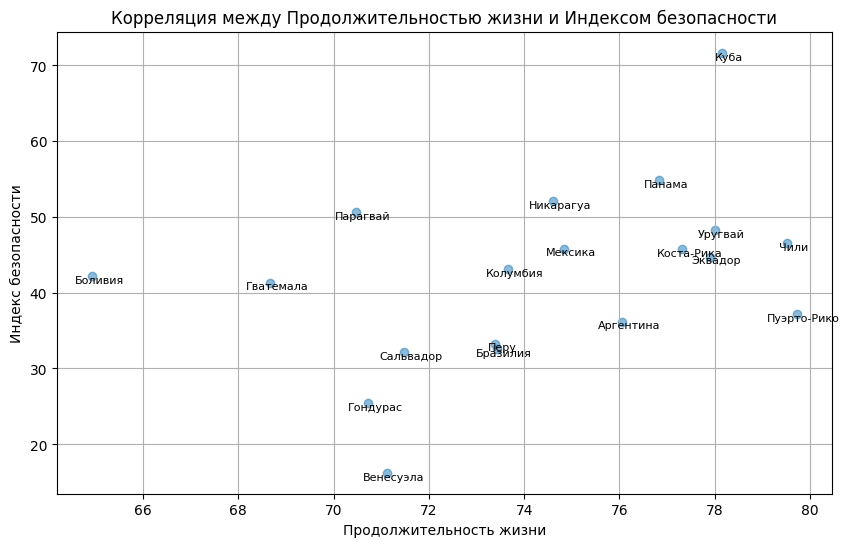

In [3]:
#3 корелляция - можно ли заполнить пропуски? (нет)
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'updated_latin_america_data.xlsx'
df = pd.read_excel(file_path)

print("Названия столбцов в DataFrame:")
print(df.columns)

df = df.dropna(subset=['Индекс безопасности'])

correlation = df['Продолжительность жизни'].corr(df['Индекс безопасности'])

print(f"Корреляция между столбцами 'Продолжительность жизни' и 'Индекс безопасности': {correlation}")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Продолжительность жизни'], df['Индекс безопасности'], alpha=0.5)
plt.title('Корреляция между Продолжительностью жизни и Индексом безопасности')
plt.xlabel('Продолжительность жизни')
plt.ylabel('Индекс безопасности')
plt.grid(True)

for i, row in df.iterrows():
    plt.annotate(row['Страна'], (row['Продолжительность жизни'], row['Индекс безопасности']),
                 textcoords="offset points", xytext=(5,-5), ha='center', fontsize=8, color='black')

plot_file_path = 'correlation_plot.png'
plt.savefig(plot_file_path)

output_file_path = 'correlation_analysis.xlsx'
df.to_excel(output_file_path, index=False)

from openpyxl import load_workbook
from openpyxl.drawing.image import Image

wb = load_workbook(output_file_path)
ws = wb.active

img = Image(plot_file_path)
ws.add_image(img, 'H1')

wb.save(output_file_path)

print(f"Файл с анализом корреляции сохранен: {output_file_path}")



Корелляция слишком низкая (0.394, тогда как говорить о зависимости можно при корелляции от 0.5), чтобы говорить, что между показателями есть зависимость, поэтому лучше не будем заменять на среднее значение - просто удалим страны для которых нет данных, т.к. о них слишком мало информации и мы не можем их рекомендовать для посещения нашим клиентам.

Теперь выведем этот график в plotly для более удобного взаимодействия

In [4]:
#4 почистим датасет и выведем в plotly
import pandas as pd
import plotly.express as px

file_path = 'updated_latin_america_data.xlsx'
df = pd.read_excel(file_path)

print("Названия столбцов в DataFrame:")
print(df.columns)

df = df.dropna(subset=['Индекс безопасности'])

correlation = df['Продолжительность жизни'].corr(df['Индекс безопасности'])

print(f"Корреляция между столбцами 'Продолжительность жизни' и 'Индекс безопасности': {correlation}")

fig = px.scatter(
    df,
    x='Продолжительность жизни',
    y='Индекс безопасности',
    title='Корреляция между Продолжительностью жизни и Индексом безопасности',
    labels={'Продолжительность жизни': 'Продолжительность жизни', 'Индекс безопасности': 'Индекс безопасности'},
    trendline="ols",
    text='Страна'
)

fig.update_traces(textposition='top center')

fig.show()

output_file_path = 'correlation_analysis.xlsx'
df.to_excel(output_file_path, index=False)

print(f"Файл с анализом корреляции сохранен: {output_file_path}")



Названия столбцов в DataFrame:
Index(['Страна', 'Продолжительность жизни', 'Координаты', 'Язык',
       'Индекс безопасности'],
      dtype='object')
Корреляция между столбцами 'Продолжительность жизни' и 'Индекс безопасности': 0.39422831534840586


Файл с анализом корреляции сохранен: correlation_analysis.xlsx


Мы убрали страны, по которым нет информации о безопасности, теперь, исходя из графиков, заметим, что несколько стран сильно негативно выделяются по показателям Продолжительность жизни и Индекс безопасности - это Боливия, Венесуэла и Гондурас. Удалим эти страны из списка возможных стран для посещения как слишком опасные/нежелательные для пребывания там - мы не можем рекомендовать эти страны для посещения нашим клиентам.

In [5]:
#5 почистим датасет по результатам анализа
import pandas as pd

file_path = 'correlation_analysis.xlsx'
df = pd.read_excel(file_path)

min_safety_indices = df['Индекс безопасности'].nsmallest(2).index

min_life_index = df['Продолжительность жизни'].idxmin()

df = df.drop(min_safety_indices).drop(min_life_index)

output_file_path = 'updated_correlation_analysis.xlsx'
df.to_excel(output_file_path, index=False)

print(f"Файл с обновленными данными сохранен: {output_file_path}")


Файл с обновленными данными сохранен: updated_correlation_analysis.xlsx


Выделим данные в датасете с самыми посещаемыми туристами странами Америки

In [7]:
#6 датасет с посещениями туристов
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://ru.wikipedia.org/wiki/Список_стран_по_туристическим_посещениям"

existing_data = pd.read_excel('updated_correlation_analysis.xlsx')

countries_list = existing_data['Страна'].tolist()

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

tables = soup.find_all('table', {'class': 'wikitable'})

if len(tables) >= 4:
    fourth_table = tables[3]
    table_data = []
    for row in fourth_table.find_all('tr'):
        cols = row.find_all(['td', 'th'])
        cols_data = [col.text.strip() for col in cols]
        if cols_data and cols_data[1] in countries_list:
            table_data.append(cols_data)

    df_tourism = pd.DataFrame(table_data, columns=["Номер", "Страна", "Посещения"])

    df_tourism = df_tourism[["Страна", "Посещения"]]

    merged_df = pd.merge(existing_data, df_tourism, on="Страна", how="left")

    output_file_path = 'updated_tourism_analysis.xlsx'
    merged_df.to_excel(output_file_path, index=False)

    print(f"Файл с обновленными данными (посещения туристов) сохранен: {output_file_path}")
else:
    print("На странице недостаточно таблиц :(")


Файл с обновленными данными (посещения туристов) сохранен: updated_tourism_analysis.xlsx


создадим много крутых графиков)

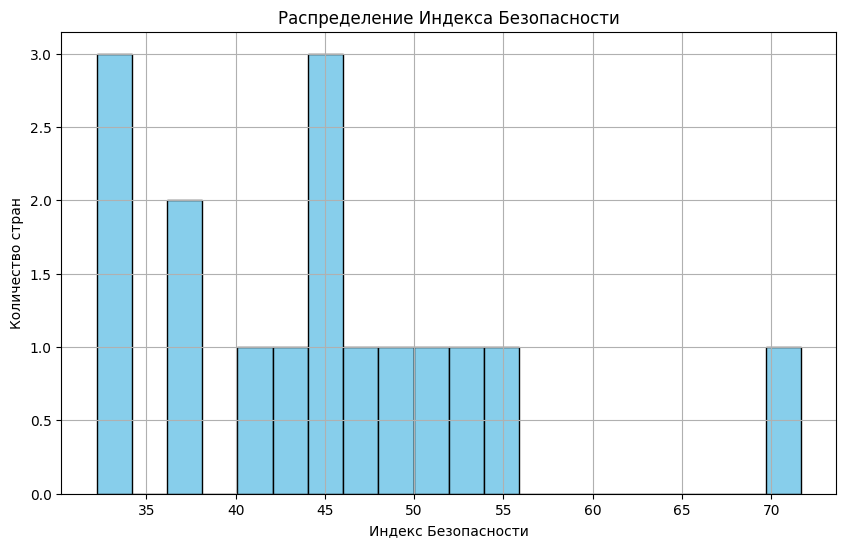

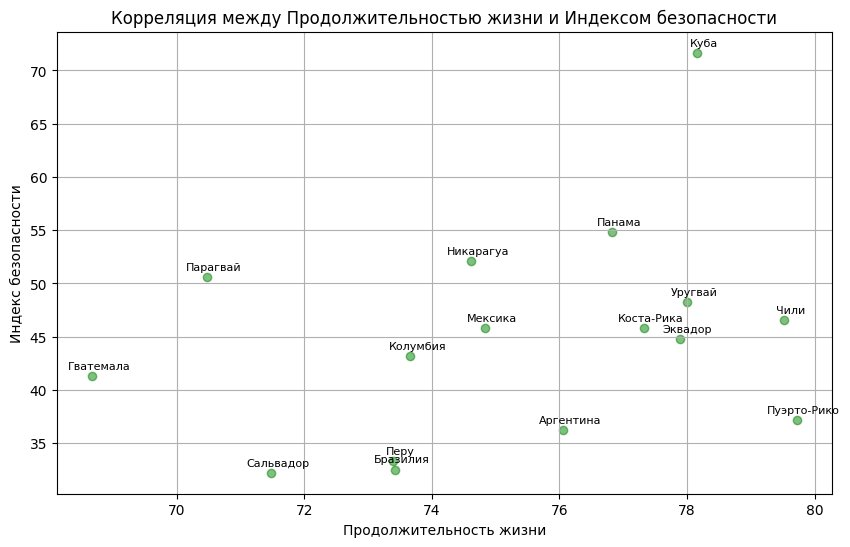

In [9]:
#7 много крутых графиков
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

file_path = 'updated_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

# 1: Гистограмма распределения индекса безопасности
plt.figure(figsize=(10, 6))
plt.hist(df['Индекс безопасности'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение Индекса Безопасности')
plt.xlabel('Индекс Безопасности')
plt.ylabel('Количество стран')
plt.grid(True)
plt.show()

# 2: График рассеяния между продолжительностью жизни и индексом безопасности
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Продолжительность жизни'], df['Индекс безопасности'], alpha=0.5, color='green')
plt.title('Корреляция между Продолжительностью жизни и Индексом безопасности')
plt.xlabel('Продолжительность жизни')
plt.ylabel('Индекс безопасности')
plt.grid(True)

for i, row in df.iterrows():
    plt.annotate(row['Страна'], (row['Продолжительность жизни'], row['Индекс безопасности']),
                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='black')

plt.show()

# 3: Интерактивный график рассеяния в plotly
fig = px.scatter(
    df,
    x='Продолжительность жизни',
    y='Индекс безопасности',
    color='Посещения',
    title='Интерактивный график: Продолжительность жизни vs Индекс безопасности',
    labels={'Продолжительность жизни': 'Продолжительность жизни', 'Индекс безопасности': 'Индекс безопасности'},
    trendline="ols",
    text='Страна'
)

fig.update_traces(textposition='top center')
fig.show()



выводы:
1) разброс между безопасностью стран Латиноамерики очень большой, поэтому при составлении финальной формулы где будем присваивать баллы странам безопасность должна идти с достаточно большим коэффициентом.
2) популярность у туристов не имеет связи с развитостью (имеем в виду продолжительность жизни) и безопасностью страны. Туристическая привлекательность это более размытое понятие, чем безопасность и развитость страны, поэтому, раз популярность не гарантирует безопасность или развитость, стоит дать этой компоненте меньший вес в итоговой формуле.

Теперь в финальный файл добавим погоду:
после отсеивания стран антилидеров и стран, по которым недостаточно информации, можно вывести доступные для посещения страны, чтобы клиент осознавал масштабность выбора


In [ ]:
# добавим погоду и выведем на карту
import pandas as pd
import re
import requests

file_path = 'updated_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

def extract_numbers(coord):
    first_number = re.search(r"(\d+)°", coord)
    second_number = re.search(r"ш\.\s*(\d+)°", coord)

    if first_number and second_number:
        latitude = float(first_number.group(1))
        longitude = float(second_number.group(1))

        if "ю" in coord:
            latitude *= -1
        if "з" in coord:
            longitude *= -1

        return latitude, longitude
    return None, None

df[["Широта", "Долгота"]] = df["Координаты"].apply(lambda x: pd.Series(extract_numbers(x)))

# сюда надо вставить api-ключ для Яндекс.Погоды
api_key = ''

def get_weather(lat, lon):
    url = f"https://api.weather.yandex.ru/v2/forecast?lat={lat}&lon={lon}"
    headers = {
        'X-Yandex-API-Key': api_key
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        weather_data = response.json()
        temp = weather_data["fact"]["temp"]
        condition = weather_data["fact"]["condition"]
        return f"{temp}°C, {condition}"
    else:
        return f"Ошибка запроса: {response.status_code}"

df["Погода"] = df.apply(lambda row: get_weather(row["Широта"], row["Долгота"]) if pd.notna(row["Широта"]) and pd.notna(row["Долгота"]) else "Нет данных", axis=1)

print(df[["Страна", "Широта", "Долгота", "Погода"]])

df.to_excel("updated_weather_data.xlsx", index=False)
print("файл 'Updated_weather_data.xlsx' сохранен.")

         Страна  Широта  Долгота               Погода
0   Пуэрто-Рико    18.0    -66.0         27°C, cloudy
1          Чили   -33.0    -70.0   5°C, partly-cloudy
2          Куба    23.0    -82.0  22°C, partly-cloudy
3       Уругвай   -34.0    -56.0  22°C, partly-cloudy
4       Эквадор    -0.0    -78.0        5°C, overcast
5    Коста-Рика     9.0    -84.0       29°C, overcast
6        Панама     8.0    -79.0       28°C, overcast
7     Аргентина   -34.0    -58.0       22°C, overcast
8       Мексика    19.0    -99.0          14°C, clear
9     Никарагуа    12.0    -86.0  28°C, partly-cloudy
10     Колумбия     4.0    -74.0         14°C, cloudy
11     Бразилия   -15.0    -47.0         32°C, cloudy
12         Перу   -12.0    -77.0  24°C, partly-cloudy
13    Сальвадор    13.0    -89.0  29°C, partly-cloudy
14     Парагвай   -25.0    -57.0     26°C, heavy-rain
15    Гватемала    14.0    -90.0  24°C, partly-cloudy
Файл 'Updated_weather_data.xlsx' сохранен.


выведем на карту

In [ ]:
#на карту
import pandas as pd
import re
import requests
import plotly.express as px
from google.colab import files

file_path = 'updated_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

def extract_numbers(coord):
    first_number = re.search(r"(\d+)°", coord)
    second_number = re.search(r"ш\.\s*(\d+)°", coord)

    if first_number and second_number:
        latitude = float(first_number.group(1))
        longitude = float(second_number.group(1))

        if "ю" in coord:
            latitude *= -1
        if "з" in coord:
            longitude *= -1

        return latitude, longitude
    return None, None

df[["Широта", "Долгота"]] = df["Координаты"].apply(lambda x: pd.Series(extract_numbers(x)))

# сюда надо вставить api-ключ для Яндекс.Погоды
api_key = ''

def get_weather(lat, lon):
    url = f"https://api.weather.yandex.ru/v2/forecast?lat={lat}&lon={lon}"
    headers = {
        'X-Yandex-API-Key': api_key
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        weather_data = response.json()
        temp = weather_data["fact"]["temp"]
        condition = weather_data["fact"]["condition"]
        return f"{temp}°C, {condition}"
    else:
        return f"Ошибка запроса: {response.status_code}"

df["Погода"] = df.apply(lambda row: get_weather(row["Широта"], row["Долгота"]) if pd.notna(row["Широта"]) and pd.notna(row["Долгота"]) else "Нет данных", axis=1)

print(df[["Страна", "Широта", "Долгота", "Погода"]])

df.to_excel("updated_weather_data.xlsx", index=False)
print("Файл  'updated_weather_data.xlsx' сохранен .")

fig = px.scatter_geo(
    df,
    lat='Широта',
    lon='Долгота',
    hover_name='Страна',
    hover_data={'Погода': True, 'Широта': True, 'Долгота': True},
    title='Погода в различных географических точках',
    projection="natural earth"
)

fig.show()


         Страна  Широта  Долгота               Погода
0   Пуэрто-Рико    18.0    -66.0         27°C, cloudy
1          Чили   -33.0    -70.0   5°C, partly-cloudy
2          Куба    23.0    -82.0  22°C, partly-cloudy
3       Уругвай   -34.0    -56.0  22°C, partly-cloudy
4       Эквадор    -0.0    -78.0        5°C, overcast
5    Коста-Рика     9.0    -84.0       29°C, overcast
6        Панама     8.0    -79.0       28°C, overcast
7     Аргентина   -34.0    -58.0       22°C, overcast
8       Мексика    19.0    -99.0          14°C, clear
9     Никарагуа    12.0    -86.0  28°C, partly-cloudy
10     Колумбия     4.0    -74.0         14°C, cloudy
11     Бразилия   -15.0    -47.0         32°C, cloudy
12         Перу   -12.0    -77.0  24°C, partly-cloudy
13    Сальвадор    13.0    -89.0  29°C, partly-cloudy
14     Парагвай   -25.0    -57.0     26°C, heavy-rain
15    Гватемала    14.0    -90.0  24°C, partly-cloudy
Файл 'updated_weather_data.xlsx' сохранен.


ИСПРАВЛЯЕМ ФАЙЛ БЕЗ ПОГОДЫ, ТК ПОГОДА МЕНЯЕТСЯ И ЕЕ НАДО ПРОВЕРЯТЬ В САМОМ КОНЦЕ
(данные были в виде строки и с пробелами. Мы извлекли из большой таблицы только нужные данные (несколько ячеек), и теперь просто изменить формат)

In [10]:
#8 изменение формата
import pandas as pd

file_path = 'updated_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

df['Посещения'] = None

df.at[0, 'Посещения'] = 4090    # ячейка 1
df.at[5, 'Посещения'] = 3876    # Ячейка 6
df.at[6, 'Посещения'] = 4452    # Ячейка 7
df.at[7, 'Посещения'] = 5060    # Ячейка 8
df.at[8, 'Посещения'] = 21333   # ячейка 9
df.at[10, 'Посещения'] = 4821   # Ячейка 11
df.at[11, 'Посещения'] = 5809   # Ячейка 12

new_file_path = 'modified_tourism_analysis.xlsx'
df.to_excel(new_file_path, index=False)

print("Изменения сохранены в новый файлик:", new_file_path)


Изменения сохранены в новый файлик: modified_tourism_analysis.xlsx


нормализация - для финальной формулы

In [11]:
#9 нормализация
import pandas as pd

file_path = 'modified_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

# заполнение пустых ячеек в столбце "Посещения" нулями
df['Посещения'].fillna(0, inplace=True)

columns_to_normalize = ['Посещения', 'Продолжительность жизни', 'Индекс безопасности']

for col in columns_to_normalize:
    max_value = df[col].max()
    min_value = df[col].min()
    if max_value != min_value:  # чтоб не делить на ноль
        df[col + '_normalized'] = (df[col] - min_value) / (max_value - min_value)

new_file_path = 'normalized_tourism_analysis.xlsx'
df.to_excel(new_file_path, index=False)

print("Изменения сохранены в новый файл:", new_file_path)


Изменения сохранены в новый файл: normalized_tourism_analysis.xlsx


<ipython-input-11-2e13d2dbaf8d>:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





10 финальный босс - формула, погода, взаимодействие с клиентом, график

In [ ]:
#10 финальный босс
import pandas as pd
import re
import requests
import plotly.express as px
from google.colab import files

file_path = 'normalized_tourism_analysis.xlsx'
df = pd.read_excel(file_path)

def extract_numbers(coord):
    first_number = re.search(r"(\d+)°", coord)
    second_number = re.search(r"ш\.\s*(\d+)°", coord)

    if first_number and second_number:
        latitude = float(first_number.group(1))
        longitude = float(second_number.group(1))

        if "ю" in coord:
            latitude *= -1
        if "з" in coord:
            longitude *= -1

        return latitude, longitude
    return None, None

df[["Широта", "Долгота"]] = df["Координаты"].apply(lambda x: pd.Series(extract_numbers(x)))

# пожалуйста, вставьте сюда ваш api-ключ для Яндекс.Погоды
api_key = '79a2d16a-9f42-4aa9-9019-832500a99a0b'

def get_weather(lat, lon):
    url = f"https://api.weather.yandex.ru/v2/forecast?lat={lat}&lon={lon}"
    headers = {
        'X-Yandex-API-Key': api_key
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        weather_data = response.json()
        temp = weather_data["fact"]["temp"]
        condition = weather_data["fact"]["condition"]
        return f"{temp}°C, {condition}"
    else:
        return f"Ошибка запроса: {response.status_code}"

df["Погода"] = df.apply(lambda row: get_weather(row["Широта"], row["Долгота"]) if pd.notna(row["Широта"]) and pd.notna(row["Долгота"]) else "Нет данных", axis=1)

optimal_temp = float(input("Какая для вас оптимальная температура по Цельсию? "))

# извлекаем температуру из столбца Погода и вычисляем модуль разницы
df['Температура'] = df['Погода'].apply(lambda x: abs(float(re.search(r'(-?\d+)°C', x).group(1)) - optimal_temp) if pd.notna(x) else None)

# Нормализуем столбец Температура
max_temp_diff = df['Температура'].max()
min_temp_diff = df['Температура'].min()
df['Температура_normalized'] = (df['Температура'] - min_temp_diff) / (max_temp_diff - min_temp_diff)

# Умножаем значения столбца Температура_normalized на -1 (чем больше отклонение от идеала, тем хуже)
df['Температура_normalized'] = df['Температура_normalized'] * -1

# создаем столбец Солнечность
df['Солнечность'] = df['Погода'].apply(lambda x: 1 if 'clear' in x.lower() else 0)

sunny_preference = int(input("Если вы любите солнечную погоду, напишите 1. Если не любите, напишите 2. Если всё равно, напишите 3. "))
if sunny_preference == 2:
    df['Солнечность'] = df['Солнечность'] * -1
elif sunny_preference == 3:
    df['Солнечность'] = df['Солнечность'] * 0

# Создаем столбец Владение
languages = input("Напишите через пробел все языки, на которых вы разговариваете: ").split()
df['Владение'] = df['Язык'].apply(lambda x: 1 if any(lang in x for lang in languages) else 0)

priority = int(input("Что для вас важнее: безопасность (напишите цифру 1), развитость страны (напишите цифру 2) или туристическая инфраструктура (напишите цифру 3)? "))
if priority == 1:
    df['Индекс безопасности_normalized'] = df['Индекс безопасности_normalized'] * 2
elif priority == 2:
    df['Продолжительность жизни_normalized'] = df['Продолжительность жизни_normalized'] * 2
elif priority == 3:
    df['Посещения_normalized'] = df['Посещения_normalized'] * 1.5

# Создаем столбец Сумма баллов
df['Сумма баллов'] = (df['Посещения_normalized'] + df['Продолжительность жизни_normalized'] +
                      df['Индекс безопасности_normalized'] + df['Солнечность'] +
                      df['Владение'] + df['Температура_normalized'])

final_file_path = 'final_boss.xlsx'
df.to_excel(final_file_path, index=False)

top_3_countries = df.nlargest(3, 'Сумма баллов')[['Страна', 'Язык', 'Погода', 'Сумма баллов']]
print("Топ-3 стран для вас:")
print(top_3_countries)


import plotly.express as px

top_3_countries = df.nlargest(3, 'Сумма баллов')

fig = px.scatter_geo(
    top_3_countries,
    lat='Широта',
    lon='Долгота',
    text='Страна',
    hover_name='Страна',
    hover_data={'Сумма баллов': True, 'Погода': True, 'Язык': True, 'Широта': False, 'Долгота': False},
    title='Топ-3 стран для вас',
    size='Сумма баллов',
    color='Сумма баллов',
    color_continuous_scale=px.colors.sequential.Plasma,
    projection="natural earth"
)

fig.show()


Какая для вас оптимальная температура по Цельсию? 25
Если вы любите солнечную погоду, напишите 1. Если не любите, напишите 2. Если всё равно, напишите 3. 1
Напишите через пробел все языки, на которых вы разговариваете: английский
Что для вас важнее: безопасность (напишите цифру 1), развитость страны (напишите цифру 2) или туристическая инфраструктура (напишите цифру 3)? 1
Топ-3 стран для вас:
        Страна                                               Язык  \
2         Куба                                          испанский   
0  Пуэрто-Рико                           испанский, английский[1]   
8      Мексика  мексиканский испанский и 68 языков коренных на...   

                Погода  Сумма баллов  
2  26°C, partly-cloudy      2.858824  
0  28°C, partly-cloudy      2.324962  
8  23°C, partly-cloudy      2.187948  
